,lagged_1m,lagged_2m,lagged_3m,lagged_4m,lagged_5m,lagged_6m,lagged_7m,lagged_8m,lagged_9m,lagged_10m,lagged_11m,lagged_12m,lagged_13m
date,,,,,,,,,,,,,
1948-03-01,35.0,-427.0,-82.0,86.0,-208.0,542.0,-352.0,202.0,-216.0,-92.0,42.0,203.0,-73.0
1948-04-01,-63.0,35.0,-427.0,-82.0,86.0,-208.0,542.0,-352.0,202.0,-216.0,-92.0,42.0,203.0
1948-05-01,-78.0,-63.0,35.0,-427.0,-82.0,86.0,-208.0,542.0,-352.0,202.0,-216.0,-92.0,42.0
1948-06-01,178.0,-78.0,-63.0,35.0,-427.0,-82.0,86.0,-208.0,542.0,-352.0,202.0,-216.0,-92.0
1948-07-01,-41.0,178.0,-78.0,-63.0,35.0,-427.0,-82.0,86.0,-208.0,542.0,-352.0,202.0,-216.0


date
1948-03-01    -63.0
1948-04-01    -78.0
1948-05-01    178.0
1948-06-01    -41.0
1948-07-01   -264.0
Name: yt_true_d1d12, dtype: float64

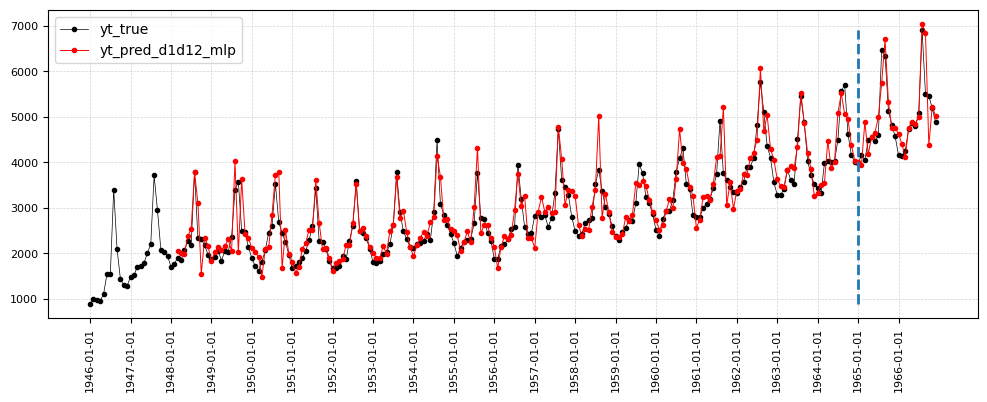

,Metrics,yt_pred_d1d12_mlp
0,MSE Train,120867.01
1,MSE Test,212155.92
2,MAE Train,243.53
3,MAE Test,301.63


In [6]:
#
# Pronositco usando un modelo mlp con differenciacion
#
# =============================================================================
import warnings

warnings.filterwarnings("ignore")

#
# Carga de datos
#
import nbimporter  #  type: ignore
import functions  #  type: ignore

df_orig = functions.load_data()
df_orig.head()

#
# Remove trend and cycle to make the series stationary
#
df_orig = functions.remove_trend_and_cycle(df_orig, yt_true_name="yt_true")
df_orig.head(20)

#
# Construcción de la matriz de regresores
#
p_max = 13
df_orig = functions.make_lagged_ts(
    df=df_orig,
    p_max=p_max,
    y_column="yt_true_d1d12",
    fmt="lagged_{}m",
)
df_orig.head(20)

#
# Remoción de los valores faltantes
#
df_dropna = df_orig.dropna()
df_dropna.head()

#
# División de los datos en entrenamiento y prueba
#
(
    X_complete,
    y_complete,
    X_train,
    y_train,
    X_test,
    y_test,
) = functions.train_test_split(
    df=df_dropna,
    x_columns=[f"lagged_{i}m" for i in range(1, 14)],
    y_column="yt_true_d1d12",
)

display(X_complete.head())
display(y_complete.head())

#
# Pronostico usando una red neuronal tipo MLP
#
from sklearn.pipeline import Pipeline  #  type: ignore
from sklearn.preprocessing import MinMaxScaler  #  type: ignore
from sklearn.compose import TransformedTargetRegressor  #  type: ignore
from sklearn.neural_network import MLPRegressor  #  type: ignore


# Crea un pipeline para automatizar la creacion de un modelo
def make_pipeline_from_model(model):
    """Create a pipeline."""
    return Pipeline(
        [
            (
                "scaler",
                MinMaxScaler(),
            ),
            (
                "regressor",
                TransformedTargetRegressor(
                    regressor=model,
                    transformer=MinMaxScaler(),
                ),
            ),
        ]
    )
  
  
  
 
  #
# Entrenamiento y pronostico
#
hidden = 4
pipeline = make_pipeline_from_model(
    model=MLPRegressor(
        hidden_layer_sizes=(hidden,hidden),
        activation="relu",
        learning_rate="adaptive",
        momentum=0.01,
        learning_rate_init=0.2,
        max_iter=10000,
        random_state=12345,
    )
)
pipeline.fit(X_train, y_train)

df_dropna[f"yt_d1d12_mlp"] = pipeline.predict(X_complete)

df_orig.loc[df_dropna.index, "yt_d1d12_mlp"] = df_dropna[f"yt_d1d12_mlp"]

df_orig[
    [
        "yt_true",
        "yt_true_d1d12",
        f"yt_d1d12_mlp",
    ]
].head(40)


#
# Integración simple y estacional
#
import numpy as np  #  type: ignore

df_orig = df_orig.assign(yt_pred_d1d12_mlp=np.nan)
df_orig.loc[df_dropna.index, "yt_pred_d1d12_mlp"] = df_dropna["yt_d1d12_mlp"]
df_orig["yt_pred_d1d12_mlp"] += df_orig["yt_true"].shift(1)
df_orig["yt_pred_d1d12_mlp"] += df_orig["yt_true"].shift(12)
df_orig["yt_pred_d1d12_mlp"] -= df_orig["yt_true"].shift(13)
df_orig[["yt_true", "yt_pred_d1d12_mlp"]].head(40)

#
# Gráfico de los pronósticos
#
functions.plot_time_series(df=df_orig, yt_col="yt_true")

#
# Almacenamiento de los resultados
#
functions.save_forecasts(df_orig)



metrics = functions.compute_evaluation_metrics(df_orig.dropna())
functions.save_metrics(metrics)
metrics
